# MLER example
Extreme conditions modeling consists of identifying the expected extreme (e.g. 100-year) response of some quantity of interest, such as WEC motions or mooring loads. 
Three different methods of estimating extreme conditions were adapted from [WDRT](https://github.com/WEC-Sim/WDRT): full sea state approach, contour approach, and MLER design wave. 
This noteboook presents the MLER approach. 

This example notebook shows users how to utilze the most likely extreme response (MLER) method. This method is an alternative to exhaustive Monte Carlo or long-term simulations for finding and evaluating wave energy converter response events at extreme loads. To accomplish this, a given RAO is combined with a wave spectrum corresponding to certain extreme sea states. MLER then generates the resulting wave profile that would cause the largest response for that degree of freedom. See full explanation and derivation of the MLER method in 

> E. Quon, A. Platt, Y.-H. Yu, and M. Lawson, “Application of the Most Likely Extreme Response Method for Wave Energy Converters,” in Volume 6: Ocean Space Utilization; Ocean Renewable Energy, Busan, South Korea, Jun. 2016, p. V006T09A022. doi: 10.1115/OMAE2016-54751.

First, we start by importing the relevant modules.  

In [1]:
import pandas as pd
import numpy as np
import mhkit.wave.resource as resource
import mhkit.loads.extreme as extreme

In this example, a simple ellipsoid shaped WEC device was modeled in WEC-Sim. We will focus on anayzing the heave response of this device. The code below simply imports RAO data as it is needed for one of the inputs.

In [2]:
wave_freq = np.linspace( 0.,1,500)
mfile = pd.read_csv('data/loads/mler.csv')
RAO = mfile['RAO'].astype(complex)
RAO[0:10]

0    1.000000+0.000000j
1    1.000005-0.000225j
2    1.000013-0.000392j
3    1.000023-0.000511j
4    1.000037-0.000589j
5    1.000052-0.000635j
6    1.000068-0.000658j
7    1.000086-0.000665j
8    1.000103-0.000820j
9    1.000103-0.000949j
Name: RAO, dtype: complex128

Next, we need to generate a wave environment that corresponds to a chosen extreme sea state. The associated parameters are selected in different ways. In this case, public wave data was used to come up with estimated 100-year sea state contour. The sea state parameters were selected somewhere along the contour.

c:\github\mhkit-python\mhkit\wave\resource.py:93: RuntimeWarning: divide by zero encountered in power
  Sf  = A_PM*f**(-5)*np.exp(-B_PM*f**(-4))
c:\github\mhkit-python\mhkit\wave\resource.py:93: RuntimeWarning: invalid value encountered in multiply
  Sf  = A_PM*f**(-5)*np.exp(-B_PM*f**(-4))


<AxesSubplot:xlabel='frequency [Hz]', ylabel='response [m^2/Hz]'>

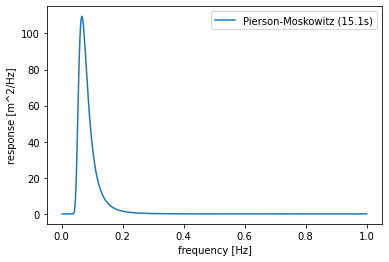

In [3]:
Hs = 9.0 # significant wave height
Tp = 15.1 # time period of waves
pm = resource.pierson_moskowitz_spectrum(wave_freq,Tp,Hs)
pm.plot(xlabel='frequency [Hz]',ylabel='response [m^2/Hz]')

Now that we have both the RAO and the spectrum of the wave environment, we can calculate the MLER conditioned wave spectrum and phase. In this case, we would like to find the wave profile that will generate a heave response of 1 meter for our WEC device. 

<AxesSubplot:xlabel='Frequency [Hz]', ylabel='[rad]'>

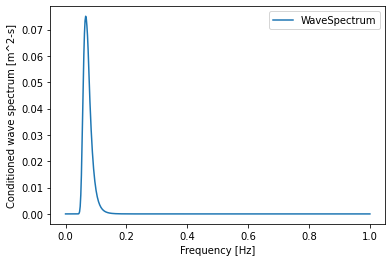

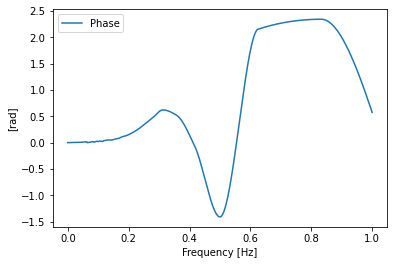

In [4]:
mler_data = extreme.MLERcoefficients(RAO,pm,1)

mler_data.plot(y='WaveSpectrum', ylabel='Conditioned wave spectrum [m^2-s]', xlabel='Frequency [Hz]')
mler_data.plot(y='Phase', ylabel='[rad]', xlabel='Frequency [Hz]')

From here, we can choose to export these coefficients to feed into other high fidelity software. However, if we wanted to get a specific height of the incoming wave, we can renormalize the wave amplitude. To do this, several inputs need to be generated in addition to the existing coefficients. 

The first is a dictionary containing information pertinent to creating time series. This dict can be easily generated using ```MLERsimulation```. In this example, the input dictionary contains the default values of this function, but the format is shown in case a user wants to adjust the parameters for their specific use case. The second input is the wave number, which was obtained using the ```wave_number``` function from the resource module. 

Finally, we decide to renormalize the wave amplitude to a desired peak height (peak to MSL). Combining all of these inputs into ```MLERwaveAmpNormalize``` gives us our new normalized mler wave spectrum. 

In [5]:
# generate parameters dict
params = (
    ('startTime',-150.0),
    ('endTime',150.0),
    ('dT',1.0),
    ('T0',0.0),
    ('startX',-300.0),
    ('endX',300.0),
    ('dX',1.0),
    ('X0',0.0)
)
parameters = dict(params)

# get simulation dict
sim = extreme.MLERsimulation(parameters=parameters)

# generate wave number k
k = resource.wave_number(wave_freq,70)
k = k.fillna(0)

peakHeightDesired = Hs/2 * 1.9
mler_norm = extreme.MLERwaveAmpNormalize(peakHeightDesired, mler_data, sim, k.k.values)

c:\github\mhkit-python\mhkit\wave\resource.py:722: RuntimeWarning: invalid value encountered in true_divide
  yi = xi*xi/np.power(1.0-np.exp(-np.power(xi,2.4908)),0.4015)


As a final step, a user might need to convert the MLER coefficients into a time series for input into higher fidelity software. We can do this by using the ```MLERexportTimeSeries``` function. The result is a dataframe showing the wave height [m] and the linear response [*] indexed by time. 

<AxesSubplot:xlabel='Time (s)', ylabel='[m] / [*]'>

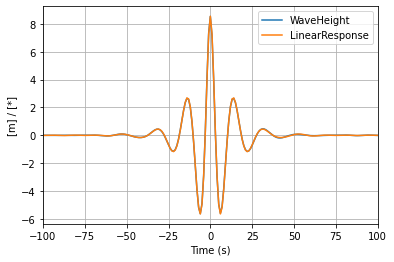

In [6]:
mler_ts = extreme.MLERexportTimeSeries(RAO.values,mler_norm,sim,k.k.values)
mler_ts.plot(xlabel='Time (s)',ylabel='[m] / [*]',xlim=[-100,100],grid=True)